In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from glob import glob

%matplotlib inline

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cyl_map = [
        ['si', 5.431, [14, 14]],
        ['ge', 5.658, [32, 32]],
        ['sige', 5.432, [14, 32]],
        ['sn', 6.4892, [50, 50]],
        ['snsi', 5.961, [14, 50]],
        ['gesn', 6.0758, [32, 50]],
        ['gaas', 5.6535, [31, 33]],
        ['alp', 5.4635, [13, 15]],
        ['alas', 5.660, [13, 33]],
        ['alsb', 6.1355, [13, 51]],
        ['gap', 5.451, [31, 15]],
        ['gasb', 6.09, [31, 51]],
        ['inp', 5.86, [49, 15]],
        ['inas', 6.05, [49, 33]],
        ['insb', 6.47, [49, 51]],

]

# Gradiant vector and Hessian matrix construction

In [13]:
H_dict = {}
G_dict = {}
a_ref_dict = {}
for info_cyl in cyl_map:
    base = info_cyl[0]
    H_root = '%s_H_scan' % base
    delta = 0.01
    H_list = []
    G_list = []
    a_ref_list = []
    H_dict[base] = H_list
    G_dict[base] = G_list
    a_ref_dict[base] = a_ref_list
    for info_a in cyl_map:
        tar = info_a[0]
        N = len(sorted(glob('%s/%s_a-%s_i??[pm]-I*' % (H_root, base, tar)))) / 2
        H = np.zeros([N, N])
        G = np.zeros(N)
        H_list.append(H)
        G_list.append(G)

        a_ref_file = glob("%s/%s_a-%s/*.out" % (H_root, base, tar))[0]
        a_ref = qtk.QMOut(a_ref_file, program='cpmd')
        a_ref_list.append(a_ref)

        di_p = []
        di_m = []
        for i in range(N):
            di_p_file = glob('%s/%s_a-%s_i%02dp-I*/*.out' % (H_root, base, tar, i))[0]
            di_m_file = glob('%s/%s_a-%s_i%02dm-I*/*.out' % (H_root, base, tar, i))[0]
    #         di_p_file = glob('%s/%s_a-%s_i%03dp-I*/*.out' % (H_root, base, tar, i))[0]
    #         di_m_file = glob('%s/%s_a-%s_i%03dm-I*/*.out' % (H_root, base, tar, i))[0]
            dp = qtk.QMOut(di_p_file, program='cpmd')
            dm = qtk.QMOut(di_m_file, program='cpmd')
            di_p.append(dp)
            di_m.append(dm)
            H[i, i] = (dp + dm - 2*a_ref) / (delta)**2
            G[i] = (dp - dm) / (2*delta)

        for i in range(N):
            for j in range(i+1, N):
                didj_file = glob('%s/%s_a-%s_i%02dj%02d*/*.out' % (H_root, base, tar, i, j))[0]
                #didj_file = glob('%s/%s_a-%s_i%03dj%03d*/*.out' % (H_root, base, tar, i, j))[0]
                didj = qtk.QMOut(didj_file, program='cpmd')

                H[i, j] = (((didj - di_p[j]) / delta) - ((di_p[i] - a_ref) / delta)) / delta
                H[j, i] = H[i, j]        

    print len(H_list)

15
15
15
15
snsi_H_scan/snsi_a-gesn_i18p-I01p03/snsi_a-gesn_i18p-I01p03.out failed with message: global name 'qmout' is not defined
snsi_H_scan/snsi_a-gesn_i20p-I01p05/snsi_a-gesn_i20p-I01p05.out failed with message: global name 'qmout' is not defined
snsi_H_scan/snsi_a-gesn_i20j21-I01p05-J01p06/snsi_a-gesn_i20j21-I01p05-J01p06.out failed with message: global name 'qmout' is not defined


IndexError: list index out of range

In [20]:
H_dict['ge'][0].shape

(30, 30)

# Prediction test

In [6]:
ref_dir = 'ref'
outs_all = []
for info_a in cyl_map:
    outs = [info_a[0], []]
    outs_all.append(outs)
    for info_cyl in cyl_map:
        cyl = info_cyl[0]
        tar = info_a[0]
        out_file = glob('%s/%s_a-%s/*.out' % (ref_dir, cyl, tar))[0]
        out = qtk.QMOut(out_file, program='cpmd')
        #outs[1].append([out.name.split('.')[0], out])
        outs[1].append(out)

In [7]:
mol_base = qtk.Molecule('xyz/ge.xyz')

In [8]:
def cyl2par(mol, size=[1, 3]):
    mol.sort(order='xyz')
    par = []
    for a in mol.type_list:
        crd = qtk.PP(a, size=size)
        vec = crd.vectorize()
        par.append([vec[0][1:], a, vec[0][0]])
    return par

def par2cyl(par, mol_base=mol_base, size=[1, 3]):
    mol = mol_base.copy()
    mol.sort(order='xyz')
    for i, crd in enumerate(par):
        print crd
        pp = qtk.PP(crd[1], size=size)
        vec = [crd[2]]
        vec.extend(crd[0])
        pp.unvectorize(vec, size[0], range(size[1], 0, -1))
        pp.name = crd[1] + '%02d' % i
        mol.setAtoms(i, string=pp)
    return mol

def mol2vec(mol_tar, mol_ref, size=[1, 3]):
    par_tar = cyl2par(mol_tar)
    par_ref = cyl2par(mol_ref)
    vec_tar = np.hstack([p[0] for p in par_tar])
    vec_ref = np.hstack([p[0] for p in par_ref])
    return vec_tar - vec_ref

In [27]:
A_dict = H_dict
for cyl, A_list in A_dict.iteritems():
    for i, A in enumerate(A_list):
        print cyl, i, A.shape

si 0 (30, 30)
si 1 (30, 30)
si 2 (30, 30)
si 3 (30, 30)
si 4 (30, 30)
si 5 (30, 30)
si 6 (30, 30)
si 7 (30, 30)
si 8 (30, 30)
si 9 (30, 30)
si 10 (30, 30)
si 11 (30, 30)
si 12 (30, 30)
si 13 (30, 30)
si 14 (30, 30)
snsi 0 (30, 30)
snsi 1 (30, 30)
snsi 2 (30, 30)
snsi 3 (30, 30)
snsi 4 (30, 30)
snsi 5 (22, 22)
snsi 6 (0, 0)
sige 0 (30, 30)
sige 1 (30, 30)
sige 2 (30, 30)
sige 3 (30, 30)
sige 4 (30, 30)
sige 5 (30, 30)
sige 6 (30, 30)
sige 7 (30, 30)
sige 8 (30, 30)
sige 9 (30, 30)
sige 10 (30, 30)
sige 11 (30, 30)
sige 12 (30, 30)
sige 13 (30, 30)
sige 14 (30, 30)
ge 0 (30, 30)
ge 1 (30, 30)
ge 2 (30, 30)
ge 3 (30, 30)
ge 4 (30, 30)
ge 5 (30, 30)
ge 6 (30, 30)
ge 7 (30, 30)
ge 8 (30, 30)
ge 9 (30, 30)
ge 10 (30, 30)
ge 11 (30, 30)
ge 12 (30, 30)
ge 13 (30, 30)
ge 14 (30, 30)
sn 0 (30, 30)
sn 1 (30, 30)
sn 2 (30, 30)
sn 3 (30, 30)
sn 4 (30, 30)
sn 5 (30, 30)
sn 6 (30, 30)
sn 7 (30, 30)
sn 8 (30, 30)
sn 9 (30, 30)
sn 10 (30, 30)
sn 11 (30, 30)
sn 12 (30, 30)
sn 13 (30, 30)
sn 14 (30, 30)


In [33]:
tars_dict = {}
prd_1_dict = {}
prd_2_dict = {}

for cyl, G_list in G_dict.iteritems():
    tars = []
    prd_1 = []
    prd_2 = []
    tars_dict[cyl] = tars
    prd_1_dict[cyl] = prd_1
    prd_2_dict[cyl] = prd_2
    for a_pos in range(len(a_ref_dict[cyl])):
        ref = a_ref_dict[cyl][a_pos]
        for tar in outs_all[a_pos][1]:
            vec = mol2vec(tar.molecule, ref.molecule)
            try:
                dE1 = G_dict[cyl][a_pos].dot(vec)
                dE2 = vec.dot(H_dict[cyl][a_pos].dot(vec)) / 2
                # only compute predictions to other crystals
                if sum(abs(vec)) > 0:
                    tars.append(tar.Et)
                    prd_1.append(ref.Et + dE1)
                    prd_2.append(ref.Et + dE1 + dE2)
            except ValueError:
                print "failed: ", cyl, i, G_dict[cyl][a_pos].shape

failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)
failed:  snsi 14 (22,)


In [35]:
tars_dict.keys()


['si', 'sn', 'sige', 'ge', 'snsi']

'gesn'
'gaas'
'alp'
'alas'
'alsb'
'gap'
'gasb'
'inp'
'inas'
'insb'


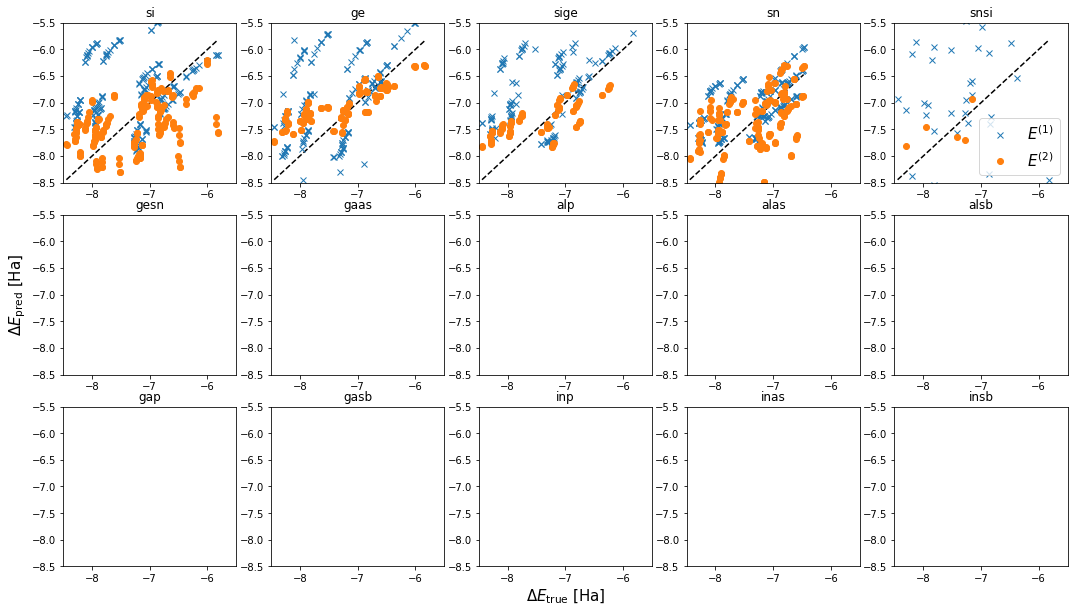

In [48]:
fig, axs = plt.subplots(3, 5, figsize=(18,10))
ax_last = None
for i, info_cyl in enumerate(cyl_map):
    cyl = info_cyl[0]
    row, col = divmod(i, 5)
    ax = axs[row][col]
    try:
        tars = tars_dict[cyl]
        prd_1 = prd_1_dict[cyl]
        prd_2 = prd_2_dict[cyl]    
        tar_min, tar_max = min(tars), max(tars)
        ax.plot([tar_min, tar_max], [tar_min, tar_max], ls='--', color='k')
        ax.plot(tars, prd_1, ls='', marker='x', label='$E^{(1)}$')
        ax.plot(tars, prd_2, ls='', marker='o', label='$E^{(2)}$')
        ax_last = ax
    except Exception as err:
        print err
    ax.set_ylim([-8.5, -5.5])
    ax.set_xlim([-8.5, -5.5])
    if row == 1 and col == 0:
        ax.set_ylabel('$\Delta E_{\mathrm{pred}}$ [Ha]', fontsize=15)
    if row == 2 and col == 2:
        ax.set_xlabel('$\Delta E_{\mathrm{true}}$ [Ha]', fontsize=15)
    ax.set_title(cyl)

ax_last.legend(loc=4, fontsize=15)

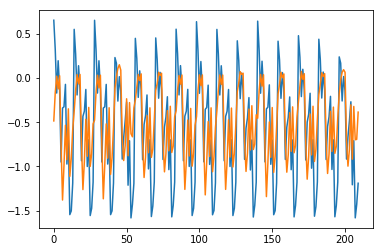

In [38]:
plt.plot(np.array(tars) - np.array(prd_1))
plt.plot(np.array(tars) - np.array(prd_2))